# 1.工具库

In [5]:
import config
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 2.下载图像数据

## 2.1 原始数据下载

In [17]:
# !curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

In [18]:
# !unzip -q kagglecatsanddogs_3367a.zip
# !ls

In [19]:
# !ls PetImages

## 2.2 删除损坏的图像数据

In [24]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(config.data_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print(f"Deleted {num_skipped} images.")

Deleted 0 images.


# 3.创建Dataset

## 3.1 创建 Dataset

In [25]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    config.data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size,
)
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    config.data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


## 3.2 数据探索可视化

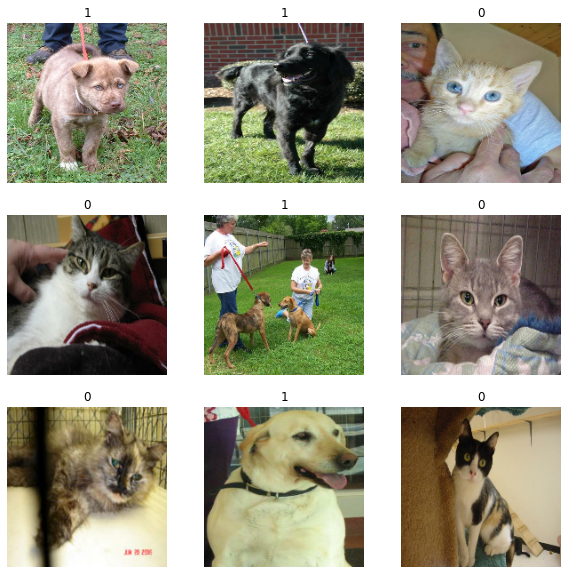

In [26]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## 3.3 数据增强

In [27]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
])

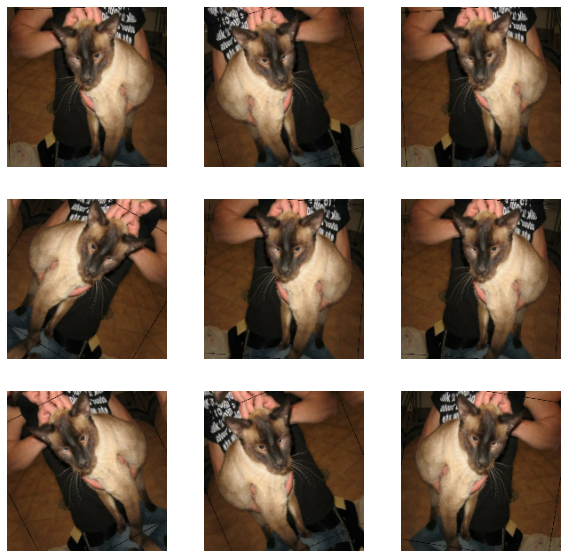

In [28]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## 3.4 数据标准化

In [22]:
# 如果使用 CPU 进行模型训练
# augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training = True), y))
# rescaling_train_ds = augmented_train_ds.map(lambda x, y: (keras.layers.experimental.preprocessing.Rescaling(1./255), y))

In [21]:
# 如果使用 GPU 进行模型训练
# input_shape = (10, 10)
# inputs = keras.Input(shape = input_shape)
# x = data_augmentation(inputs)
# x = layers.experimental.preprocessing.Rescaling(1./255)(x)

## 3.5 数据配置

In [20]:
train_ds = train_ds.prefetch(buffer_size = 32)
validation_ds = validation_ds.prefetch(buffer_size = 32)

# 4.构建模型

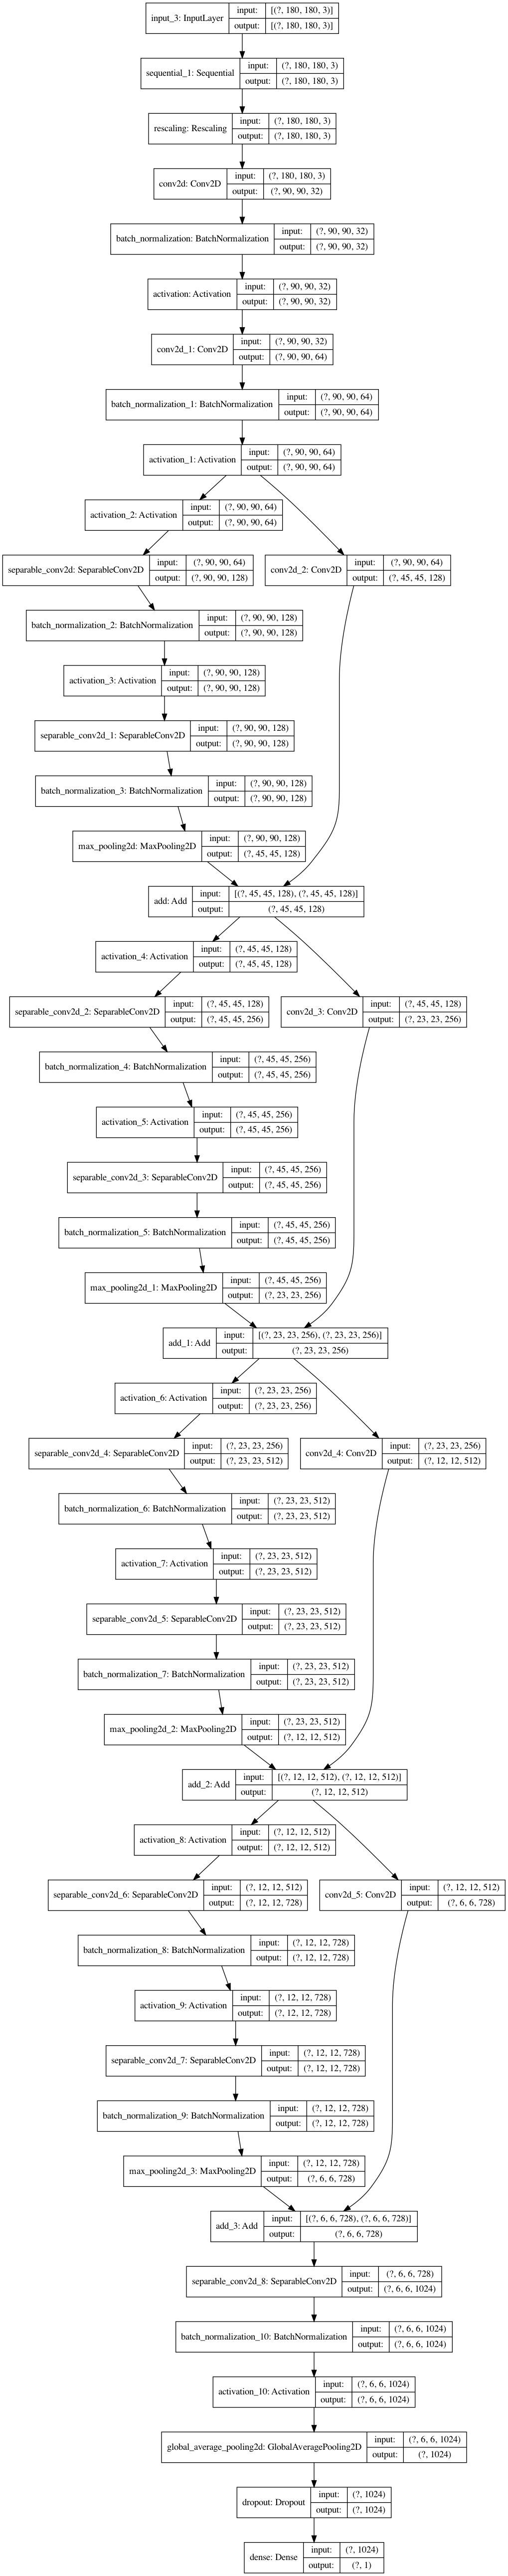

In [29]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape = input_shape)
    
    # 图像增强
    x = data_augmentation(inputs)
    
    # -----------------------------
    # Entry block
    # -----------------------------
    # 数据标准化
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    
    x = layers.Conv2D(32, 3, strides = 2, padding = "same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv2D(64, 3, padding = "same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    # Set aside residual
    previous_block_activation = x
    
    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding = "same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding = "same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.MaxPooling2D(3, strides = 2, padding = "same")(x)
        
        # Project residual
        residual = layers.Conv2D(size, 1, strides = 2, padding = "same")(previous_block_activation)

        # Add back residual
        x = layers.add([x, residual])
        
        # Set aside next residual
        previous_block_activation = x
        
    x = layers.SeparableConv2D(1024, 3, padding = "same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation = activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape = image_size + (3,), num_classes = 2)
keras.utils.plot_model(model, show_shapes = True)

# 5.训练模型

In [31]:
epochs = 50
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5")
]
model.compile(
    optimizer = keras.optimizers.Adam(1e-3),
    loss = "binary_crossentropy",
    metrics = ["accuracy"],
)
model.fit(train_ds, epochs = epochs, callbacks = callbacks, validation_data = validation_ds)